
#  FEATURE ENGINEERING AND MODEL DEVELOPMENT

In this notebook, we 
1. Engineer features to model major components of the time series( trends and seasons) and 
2. Build forecasting hybrids that combine the strength of complementary models

In [90]:
# importations
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
from datetime import datetime, timedelta

from xgboost import XGBRegressor

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf


## Load Data

In [38]:
## Load datasets
store_sales = pd.read_csv("../data/raw/train.csv", 
                   dtype={
                       "store_nbr":"category", 
                       "family":"category",
                       "sales":"float64",
                        "id":"int32",
                        "onpromotion":"int32"
                       }, 
                   parse_dates=["date"], index_col=False)

holiday_events = pd.read_csv("../data/raw/holiday_events.csv", 
                    dtype={
                        "type":"category",
                        "locale":"category",
                        "locale_name":"category",
                        "description":"category",
                        "transferred":bool
                    },
                    index_col=["date"], 
                    parse_dates=True, 
                    date_format="%Y-%m-%d")
holiday_events = holiday_events.drop(columns=holiday_events.columns[0])

oil = pd.read_csv("../data/processed/01_oil_further_analysis.csv", 
                    index_col=["date"], parse_dates=True, 
                    date_format="%Y-%m-%d" )

stores = pd.read_csv("../data/raw/stores.csv", 
                     dtype={"store_nbr":"category", 
                            "city":"category",
                            "state":"category",
                            "type":"category",
                            "cluster":"category"
                            },
                     index_col=0)

In [41]:
store_sales["date"] = store_sales.date.dt.to_period("D") # change DatetimeIndex to PeriodIndex
store_sales = store_sales.set_index(["store_nbr", "family", "date"]).sort_index()
store_sales

id      sales  onpromotion
store_nbr family     date                                       
1         AUTOMOTIVE 2013-01-01        0   0.000000            0
                     2013-01-02     1782   2.000000            0
                     2013-01-03     3564   3.000000            0
                     2013-01-04     5346   3.000000            0
                     2013-01-05     7128   5.000000            0
...                                  ...        ...          ...
9         SEAFOOD    2017-08-11  2993759  23.831000            0
                     2017-08-12  2995541  16.859001            4
                     2017-08-13  2997323  20.000000            0
                     2017-08-14  2999105  17.000000            0
                     2017-08-15  3000887  16.000000            0

[3000888 rows x 3 columns]

- visualizing the sales series across all series is impractical as there are about 1800 series (store-family combinations) 
- to identiy common trends and patterns across different store-famiy combinations, we do an aggregated analysis using average daily sales 
- this can be useful for understanding the overall market trends seasonalities, or other shared characteristics. 
- once we have gained insights from the aggregated data, we perform feature engineering to capture these patterns 
- trade-off here is that we may lose some granularity and the ability to capture nuances specific to individual series. It's a balance between simplicity and detail

In [43]:
## average sales
average_sales = store_sales.groupby("date")["sales"].mean()
average_sales

date
2013-01-01      1.409438
2013-01-02    278.390807
2013-01-03    202.840197
2013-01-04    198.911154
2013-01-05    267.873244
                 ...    
2017-08-11    463.733851
2017-08-12    444.798280
2017-08-13    485.768618
2017-08-14    427.004717
2017-08-15    427.980884
Freq: D, Name: sales, Length: 1684, dtype: float64

## Engineering Trend

- Use moving average plot to understand the structure of the trend in the data
- engineer features to capture the trend in the data


In [22]:
## change default plotting settings

plt.style.use(style='fivethirtyeight') 

plt.rc(
    "figure",             # figure settings
    autolayout=True,
    figsize=(20, 6),
    titleweight="bold",
    titlesize=18,
)

plt.rc(
    "axes",                    # axes settings
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10
)

%config InlineBackend.figure_format = "retina" # increase resolution

plot_params = dict(
    style=".-",
    color="0.75",
    markerfacecolor="0.25",
    markeredgecolor="0.25",
    
)


### Identify Trend
Using moving average plot, we visually investigate the structure of the trend component in our series

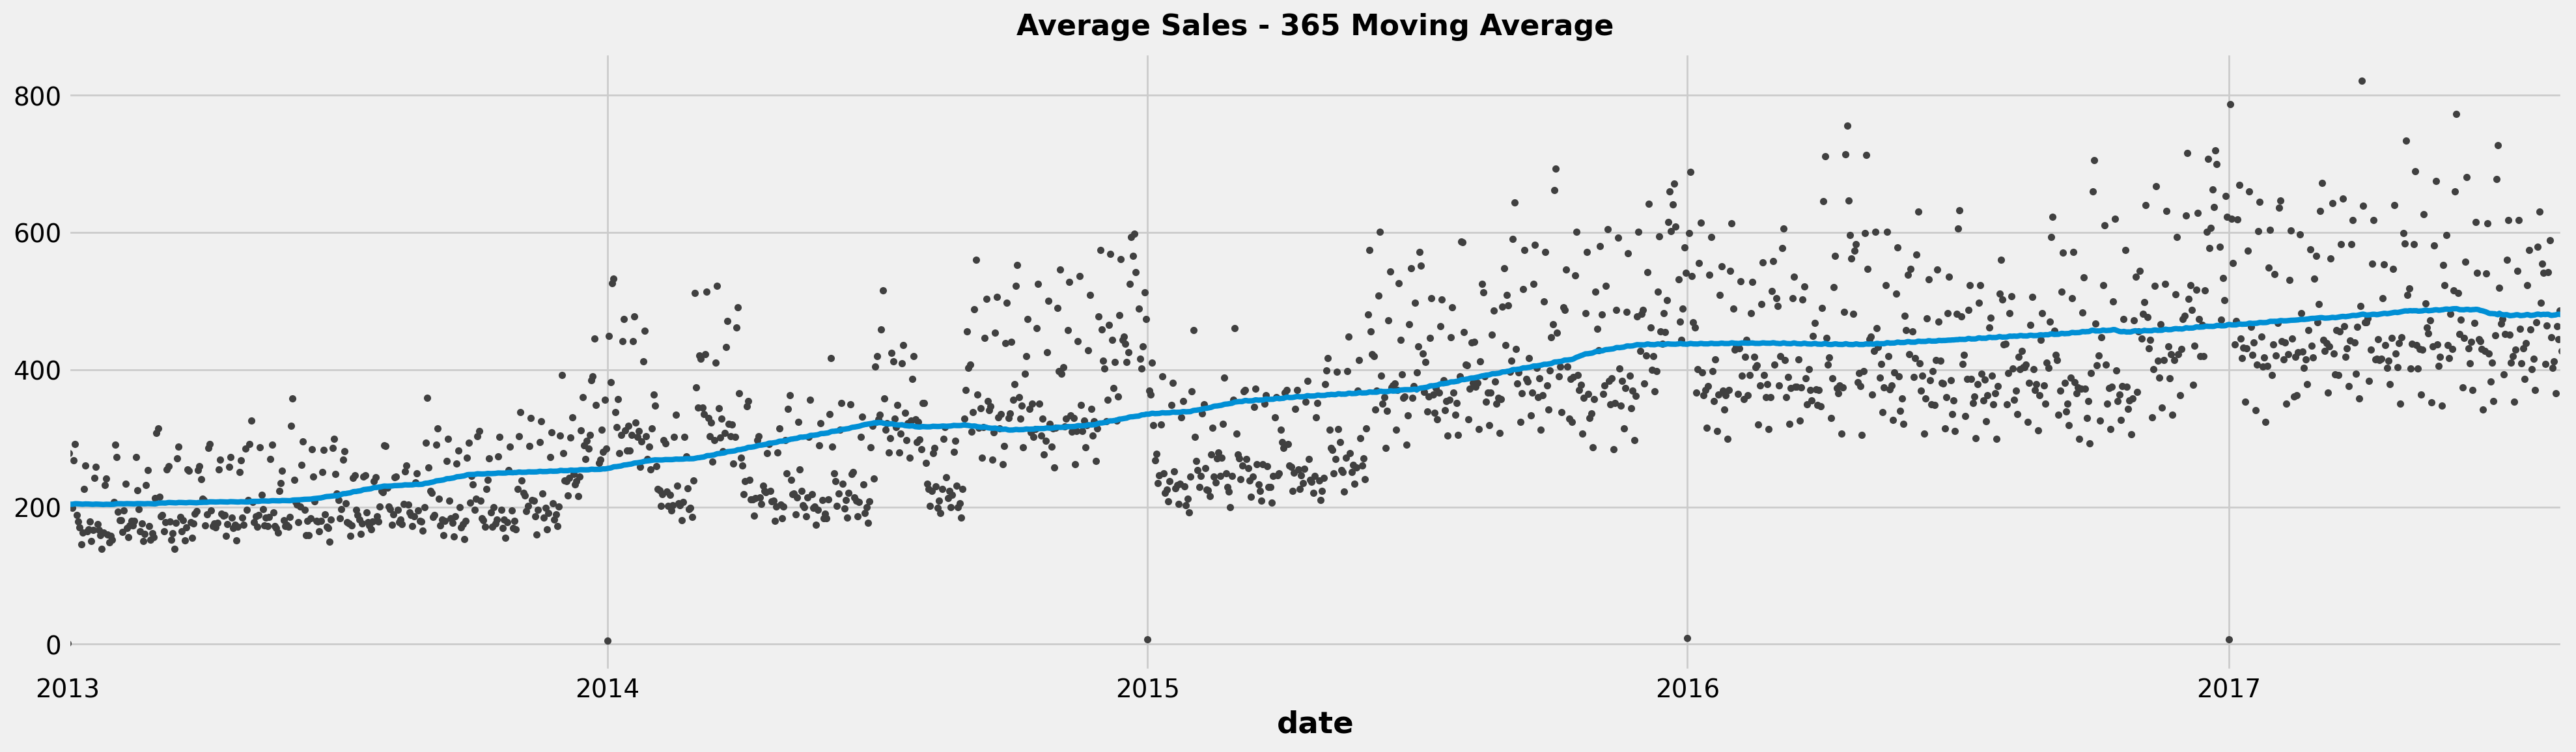

In [45]:
## estimate trend using moving average plot

trend = average_sales.rolling(
    window=365,    # smooth out short-term fluctuations within the year 
    center=True,
    min_periods=183, # min non null values in window to compute average. using half of window size
).mean()


# create MA plot
ax = average_sales.plot(style=".", color="0.25")
trend.plot(ax=ax, linewidth=3, legend=False, title="Average Sales - 365 Moving Average");

There seems to be somewhat upward linear trend in the data

### Although using all available data can provide a comprehensive understanding of the underlying patterns and trends in the time series, focusing on the most recent data -- say 2017 data -- may be more relevant since we're interested in capturing the most current bahaviour and making short-term predictions i.e. forecasting just a day into the future. 

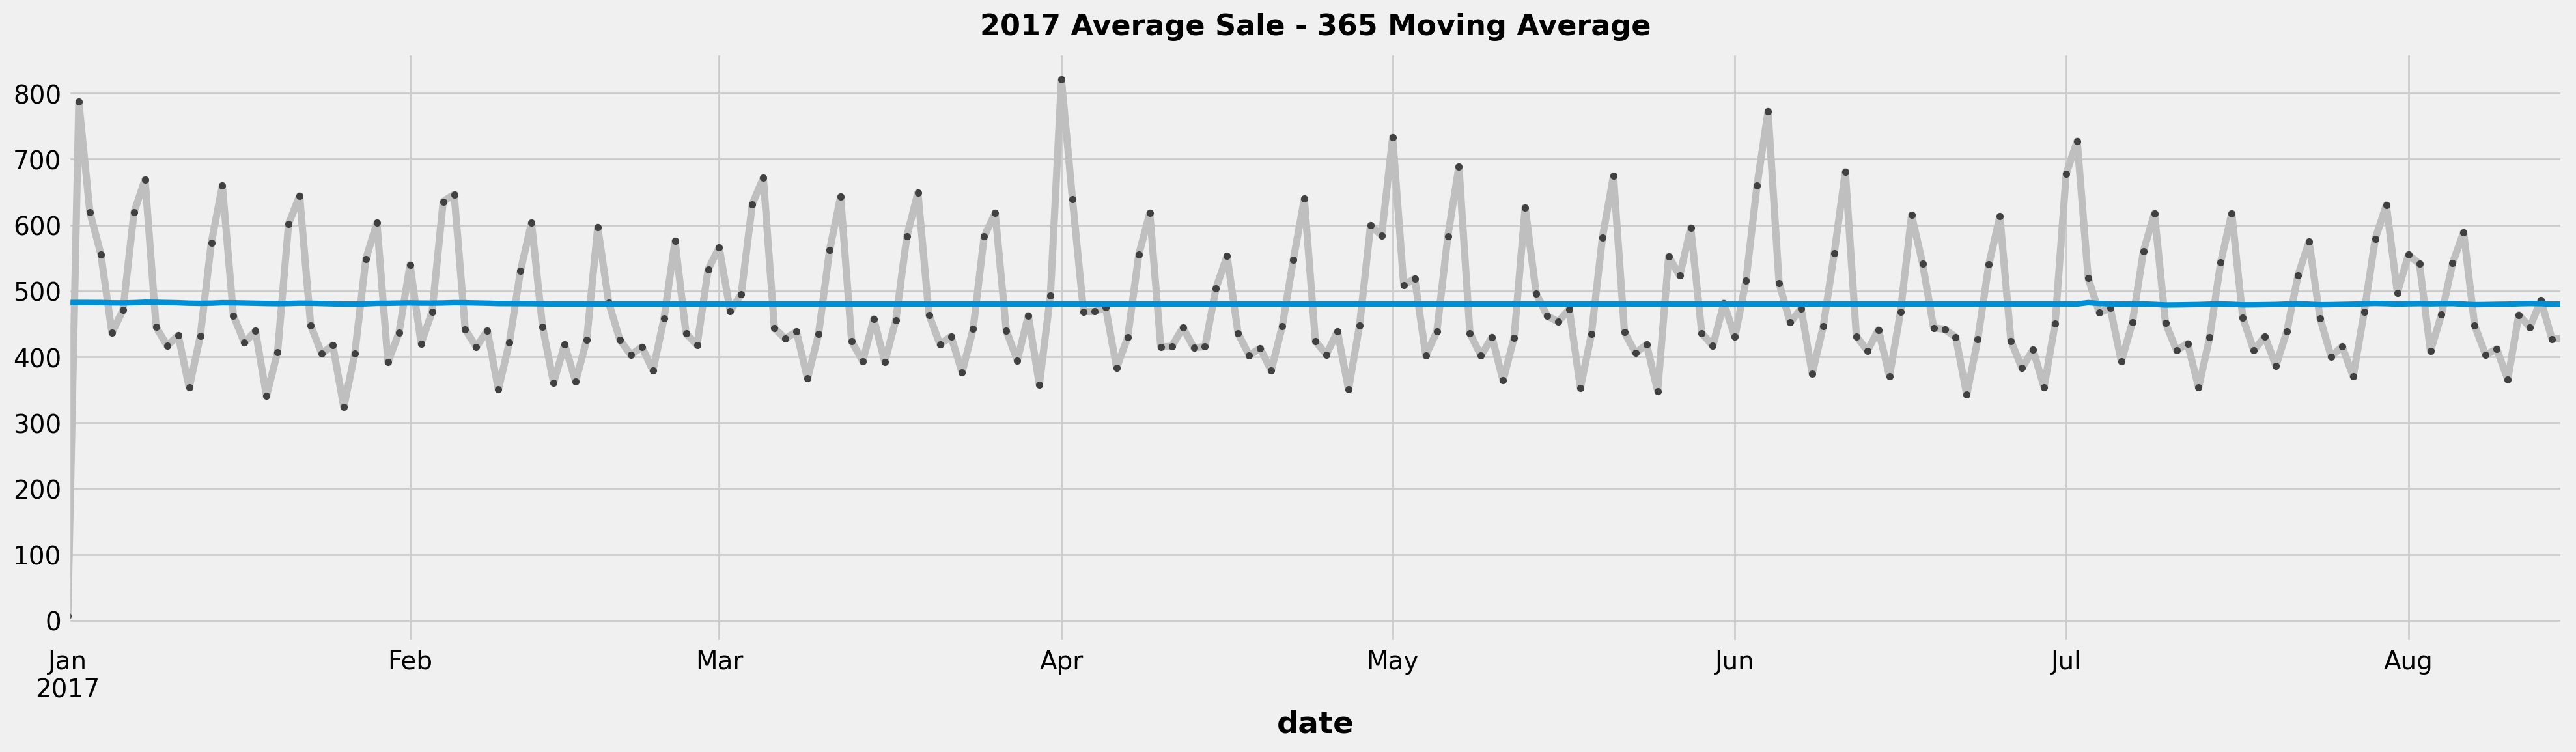

In [52]:
average_sales_2017 = average_sales.loc["2017"] 

trend = average_sales_2017.rolling(
    window=365, # smooth out short-term fluctuations
    center=True,
    min_periods=15, 
).mean()


# create MA plot
ax = average_sales_2017.plot(**plot_params)
trend.plot(ax=ax, linewidth=3, legend=False, title="2017 Average Sale - 365 Moving Average");

- The trend line is horizontal, which indicates that there is no significant upward or downward movement in the data over time. 
- Data points fluctuates around a constant mean value, suggesting a stable behaviour
- Since there is no discernible trend over time, we can focuse on investigating the structure of the seasonality in the data

## Engineering Seasonality 

- use seasonal plots and periodograms to investigate structure of seasonality 
- engineer features to capture seasonality based on insights


### Identify Seasonality

- Just as MA plot can be used to identify trend, seasonal plot, periodograms, or correlograms like acf or pacf can also be used to identify seasonality 
- It shows segments of series plotted against some common period, the period being the "season" you want to observe. 

In [77]:
## define seasonal plot function

def seasonal_plot(X, y, period, freq, ax=None):
    """generates a seasonal plot showing segments of series plotted against some common period. 

    :param X: feature matrix
    :type X: DataFrame
    :param y: series feature (a column in X)
    :type y: Series
    :param period: season to be observed
    :type period: str (a column in X)
    :param freq: number of observation in a season
    :type freq: str (a column in X)
    :param ax: plotting axes, defaults to None
    :type ax: axes, optional
    :return: a plot
    :rtype: axes
    """
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    """_summary_

    :param ts: _description_
    :type ts: _type_
    :param detrend: _description_, defaults to 'linear'
    :type detrend: str, optional
    :param ax: _description_, defaults to None
    :type ax: _type_, optional
    :return: _description_
    :rtype: _type_
    """
    
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax



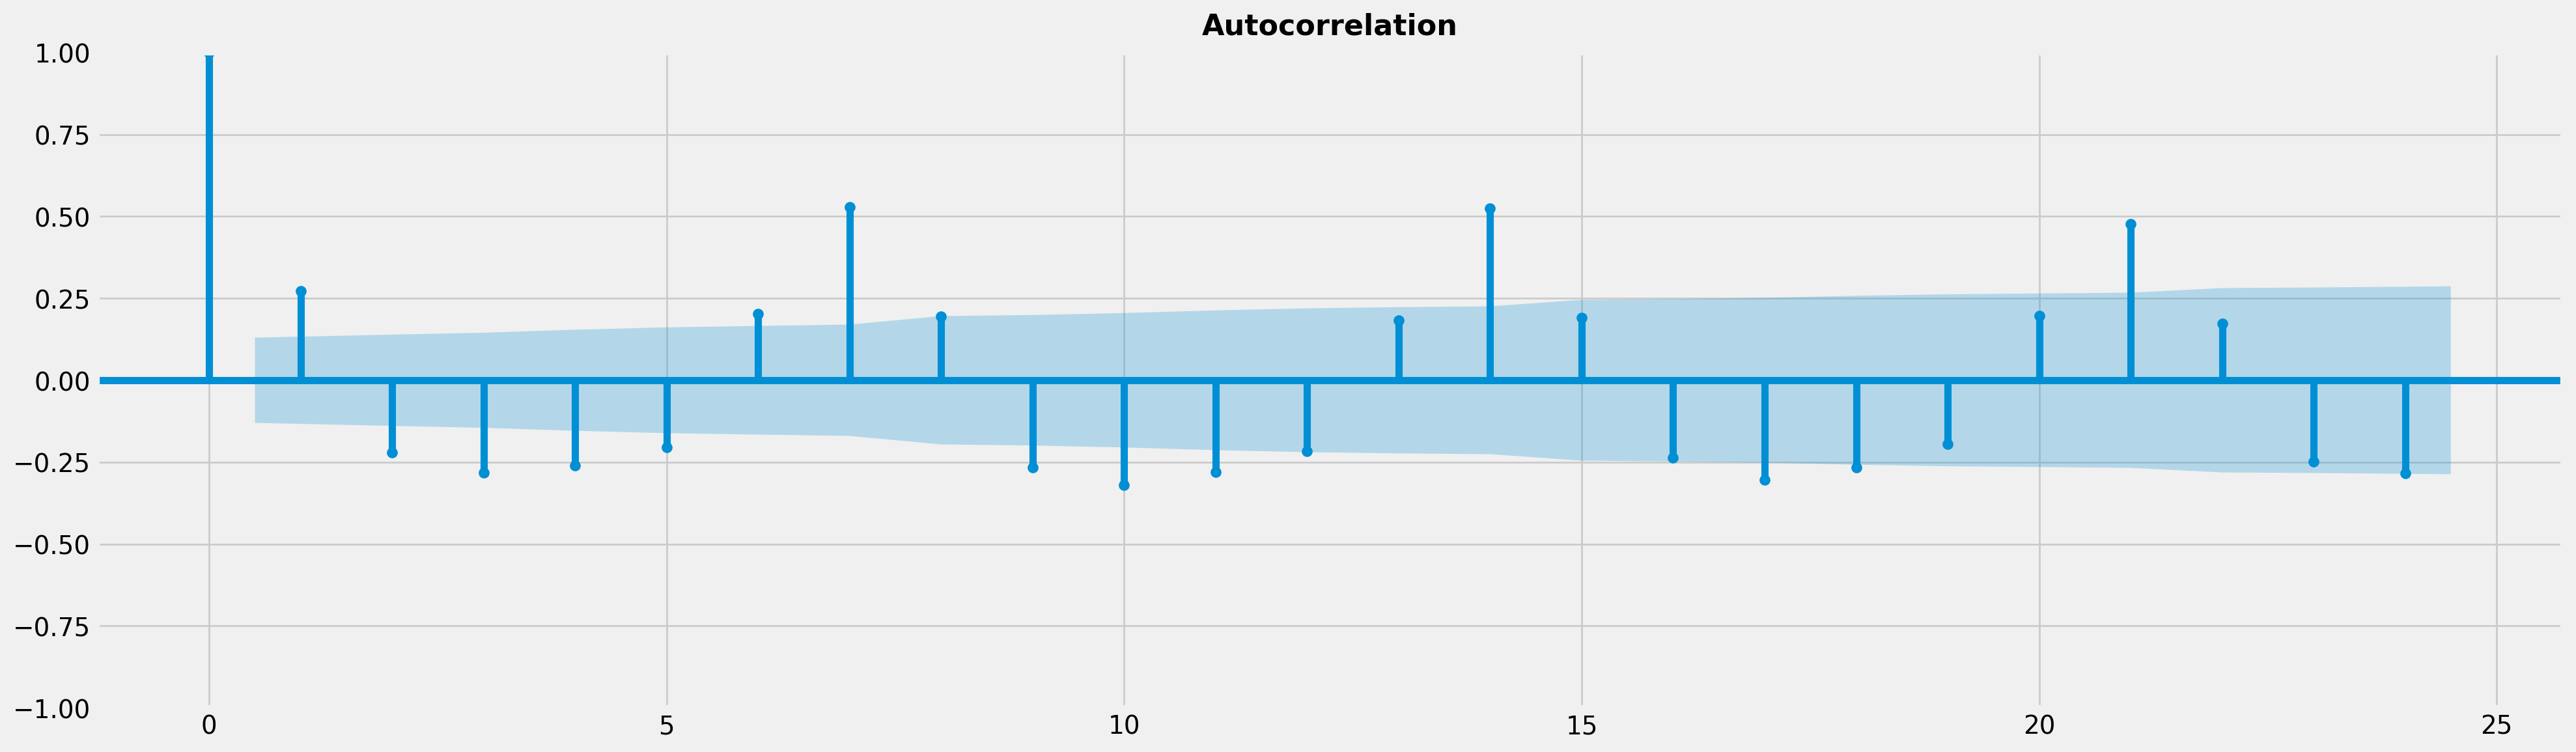

In [86]:
acf_plot = plot_acf(average_sales_2017);

aucocorrelation plot shows that weekly lags are correlated to the series: a possible indication of weekly seasonality

In [72]:
## visualize weekly and yearly period of daily observations

X = average_sales_2017.copy()
X = X.to_frame()

# days within a week
X["day"] = X.index.dayofweek
X["week"] = X.index.week 

X.head()

,sales,day,week
date,,,
2017-01-01,6.780304,6,52
2017-01-02,786.928379,0,1
2017-01-03,619.740224,1,1
2017-01-04,555.608004,2,1
2017-01-05,436.375395,3,1


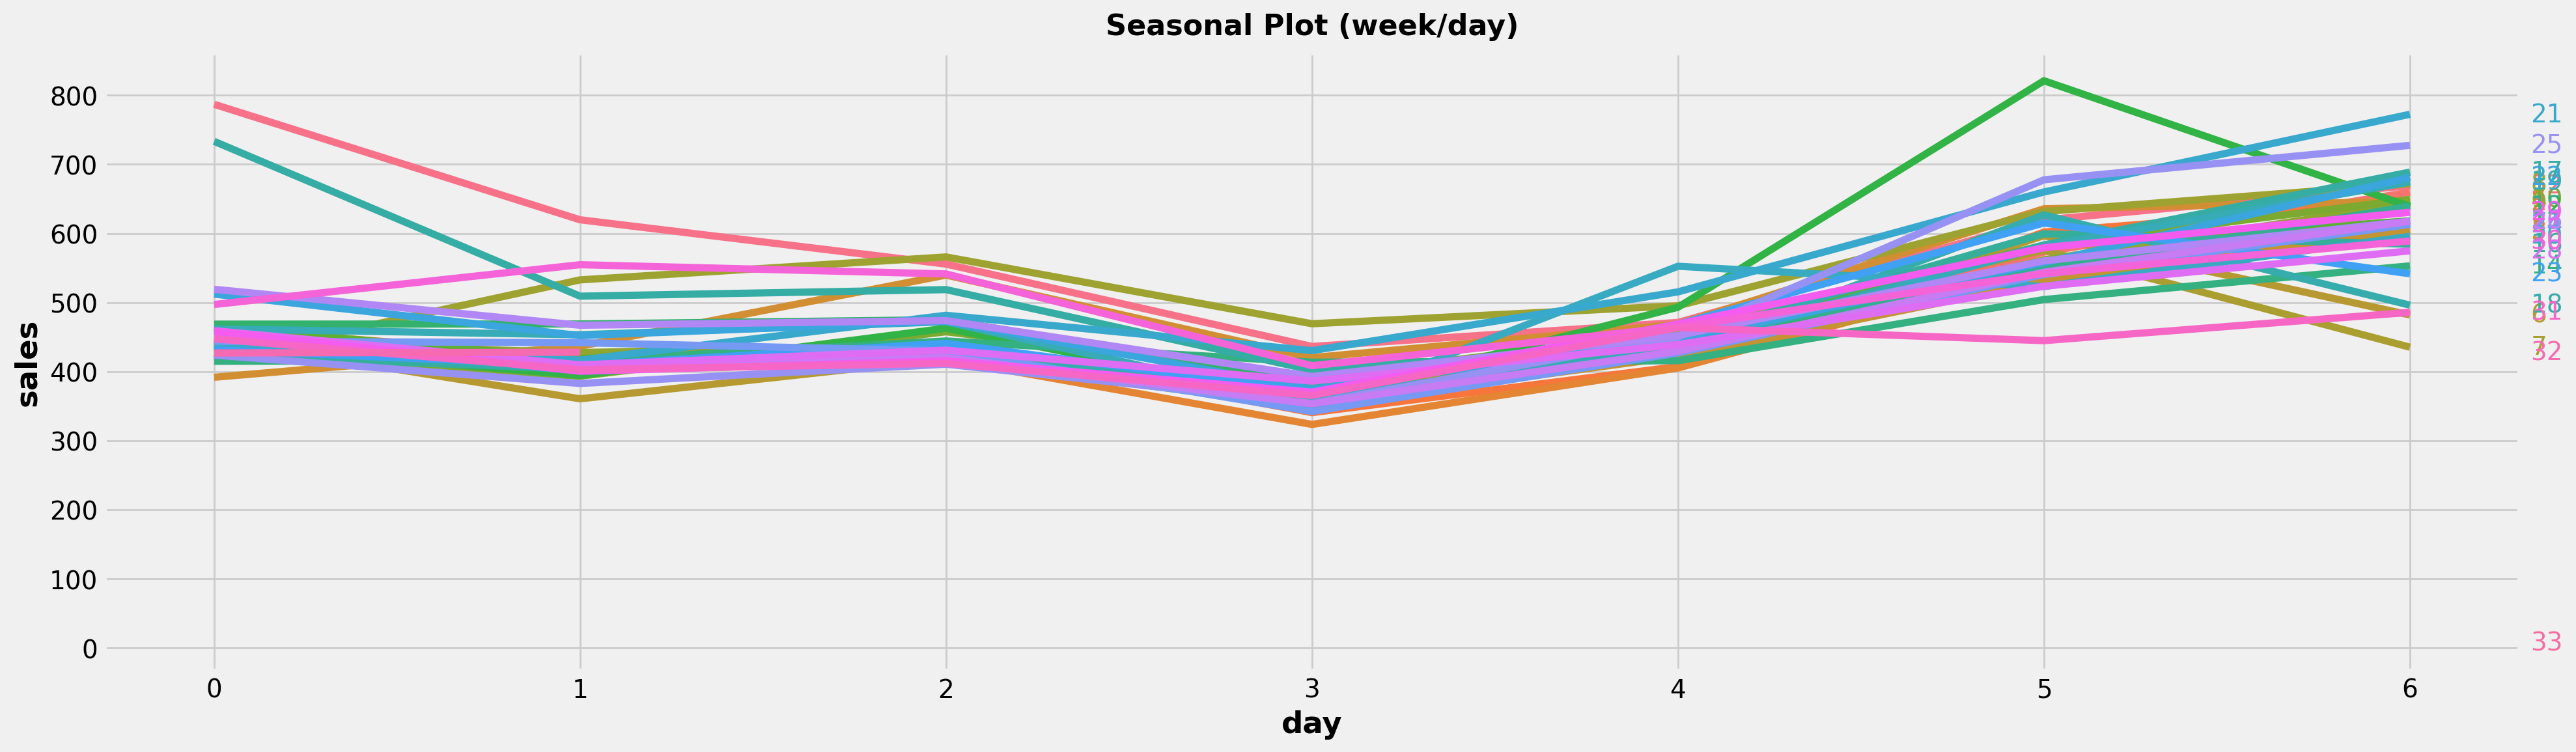

In [76]:
fig, ax = plt.subplots()

seasonal_plot(X=X, y="sales", period="week", freq="day", ax=ax);

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

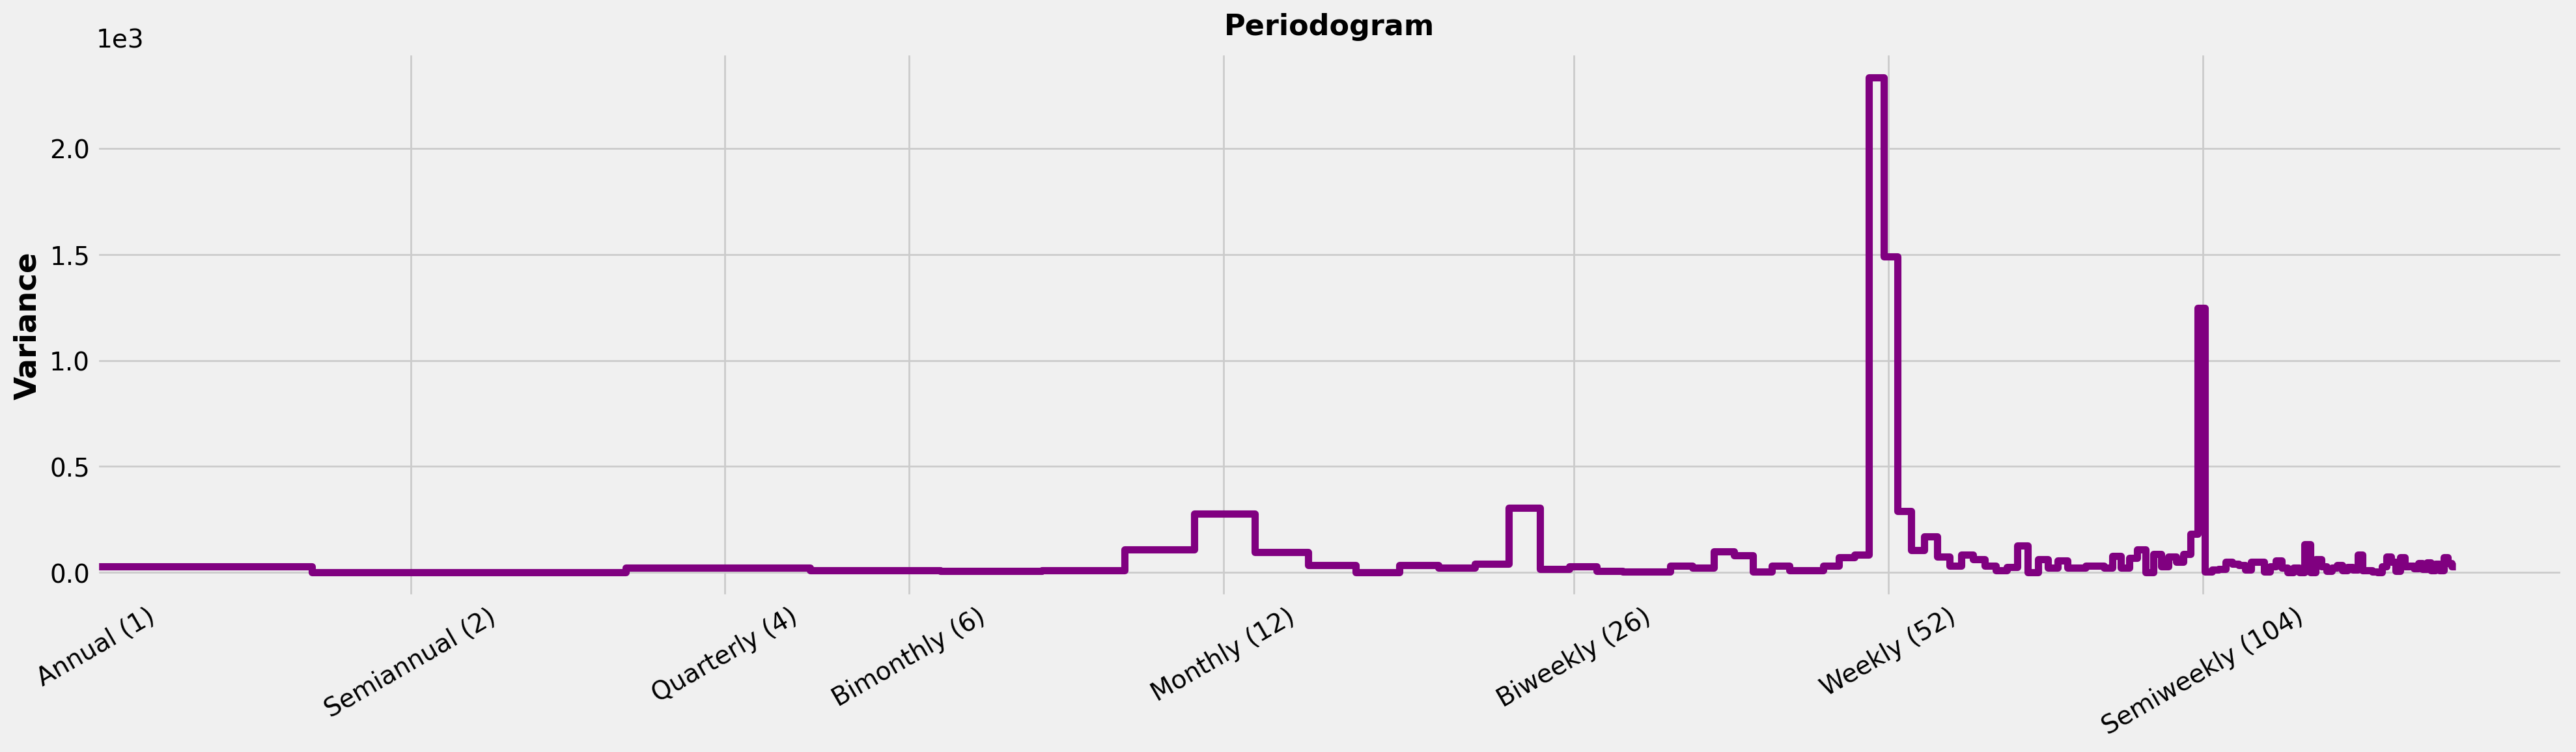

In [78]:
plot_periodogram(X.sales)

Both seasonal plot and periodogram suggest a strong weekly seasonality. From the periodogram, it appears there may be some monthly and biweekly components as well. In fact, the notes to the Store Sales dataset say wages in the public sector are paid out biweekly, on the 15th and last day of the month -- a possible origin for these seasons.


### Create Seasonal Features

- create seasonal indicators for weekly seasons
- create fourier features of order 4 for monthly seasons: i.e create sin/cos curve patterns that repeat 4 times or less a Month. 
- we'll create our seasonal features using DeterministicProcess. 
- We use two seasonal periods(monthly and weekly) 


### Train/Test split

In [99]:
train_end_date = datetime(2017, 6, 30)

train_df = average_sales_2017.loc[:train_end_date]
eval_df = average_sales_2017.loc[train_end_date + timedelta(days=1):]

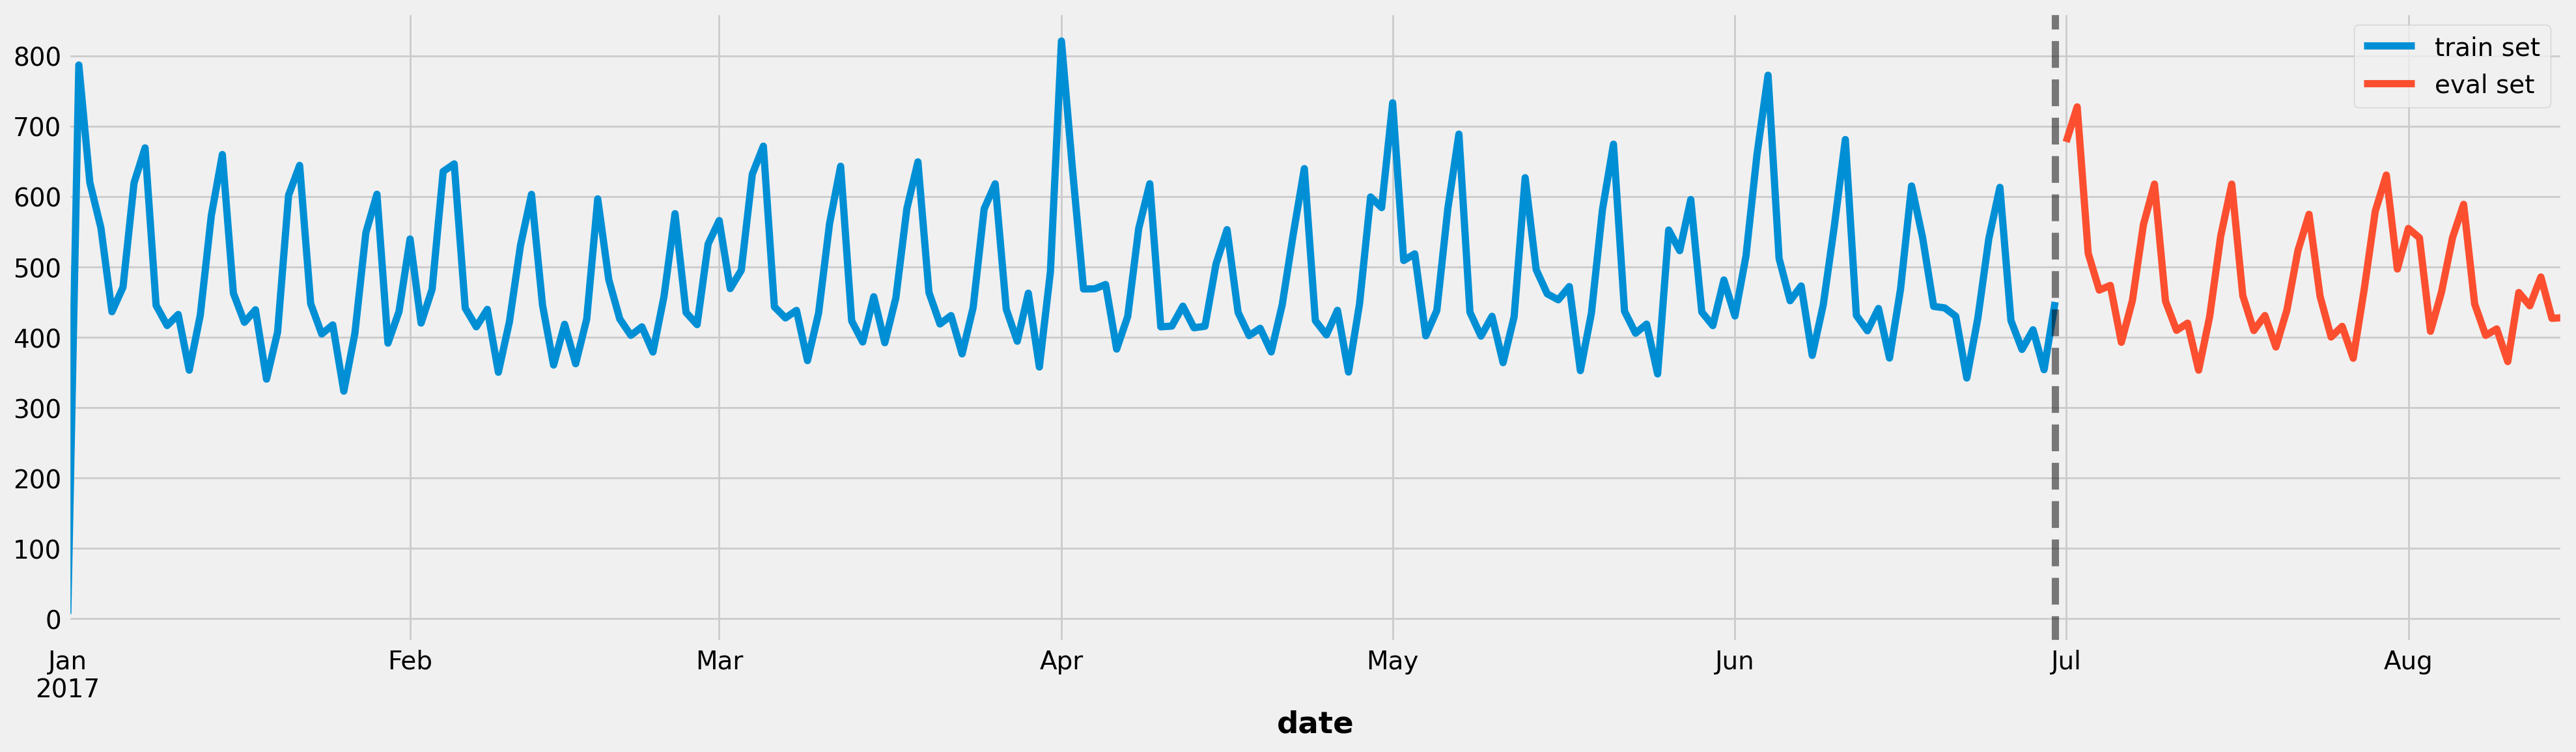

In [100]:
ax = train_df.plot(label="train set")
eval_df.plot(ax=ax, label="eval set")
plt.axvline(x=train_end_date, color="k", linestyle="--", alpha=0.5)
ax.legend()

In [82]:
## generate seasonal features from datetime index. 
y = average_sales_2017.copy()

fourier = CalendarFourier(freq="M", order=4)

dp = DeterministicProcess(
    index=y.index,
    order=0, #  exclude trend feature
    constant=True,
    seasonal=True,
    additional_terms=[fourier],
    drop=True    
)

X = dp.in_sample() 
X.head()


,const,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,
2017-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-02,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2017-01-03,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649
2017-01-04,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758
2017-01-05,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869


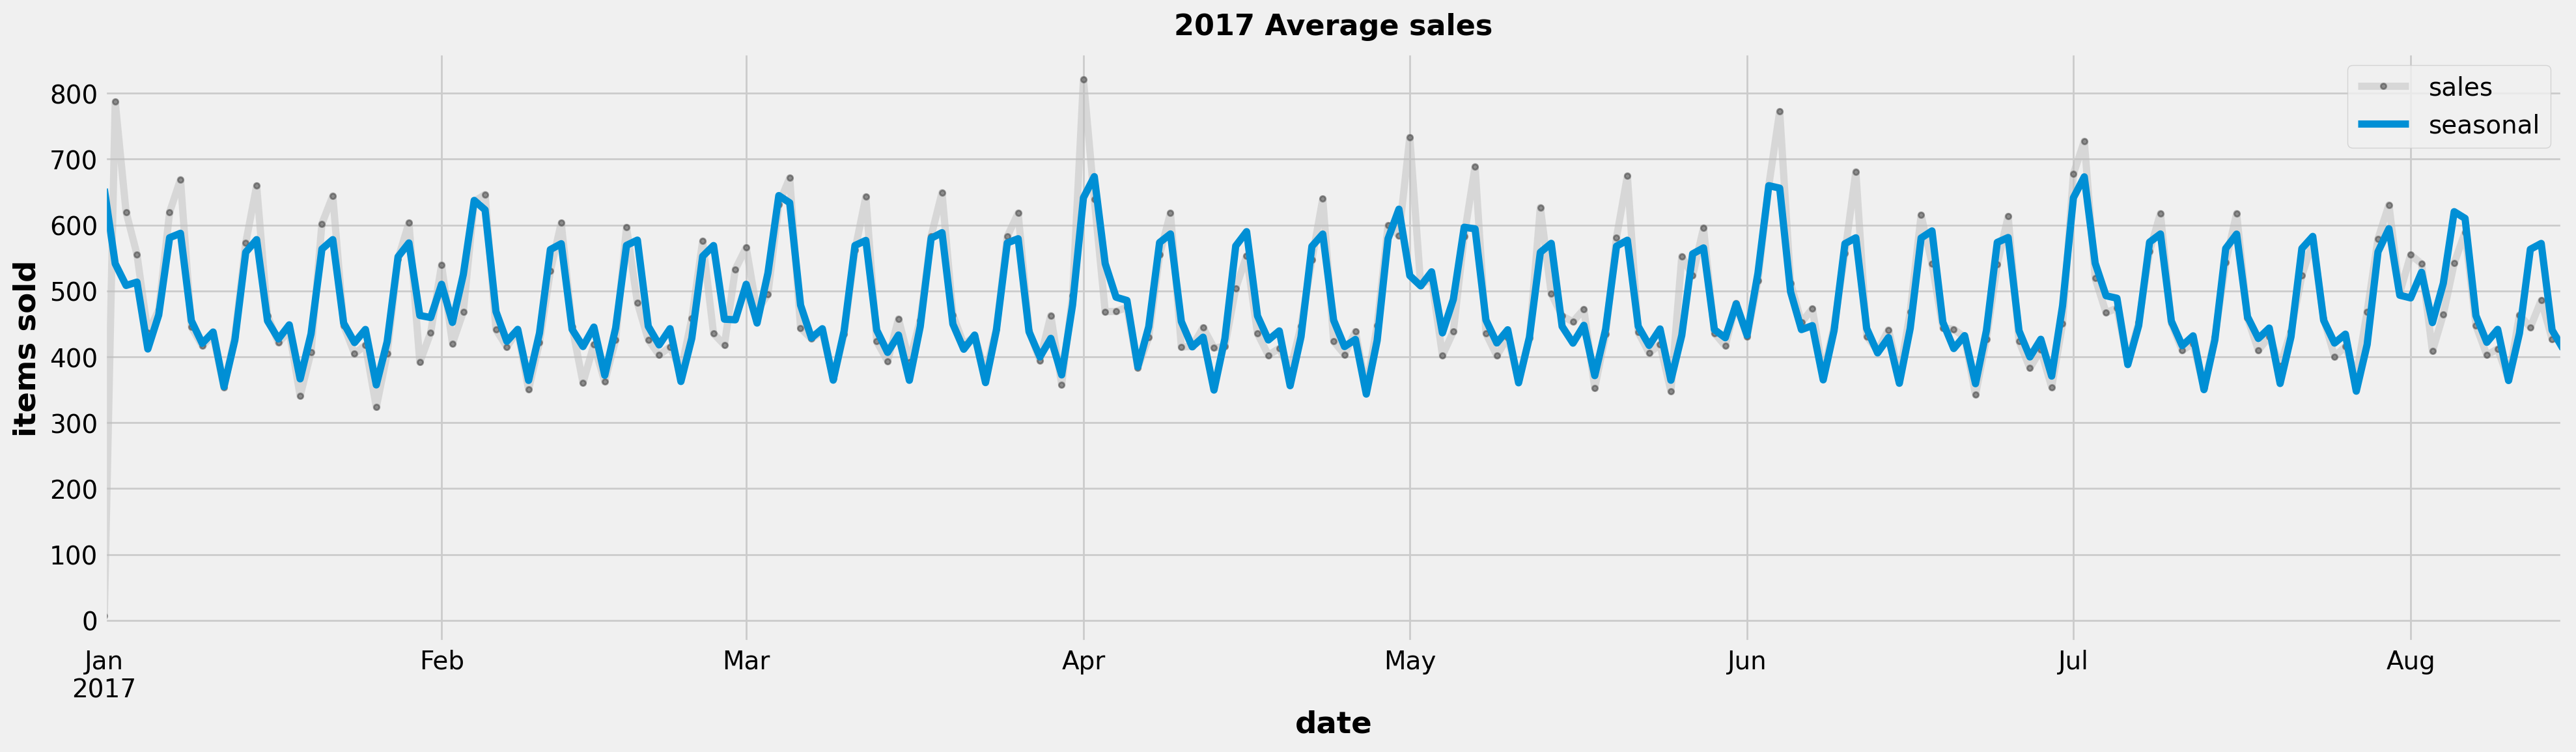

In [84]:
# Fit a seasonal model 

model = LinearRegression(fit_intercept=False) # bias already contained in DeterministicProcess
fitted_model = model.fit(X, y)

y_preds = pd.Series(
    fitted_model.predict(X),
    index=X.index,
    name="Fitted"
)

#plot predictions
ax = y.plot(**plot_params, alpha=0.5, title="2017 Average sales", ylabel="items sold")
y_preds.plot(ax=ax, label="seasonal")
ax.legend();


- Our predictions seem to follow the pattern in the series.
- But, how can we tell if our model has sufficiently learned the components of the series and there's no more improvements that can be made?
- we use the concept of white noise








### White Noise
A time series is said to be white noise if: 

1. mean is zero
2. std is constant over time
3. corr between lags is 0 

- white noise is not predictable. 
- time series models are generally represented as: $y_t = signal + noise$
- if we can show that the residuals of our model is white noise, then we can conclude that we have sufficiently learned from the time series 
- we may test if the residuals are white noise using: 
1. visual inspections
2. check ACF. correlogram should show that lags are not sifnificant or near insignificance 


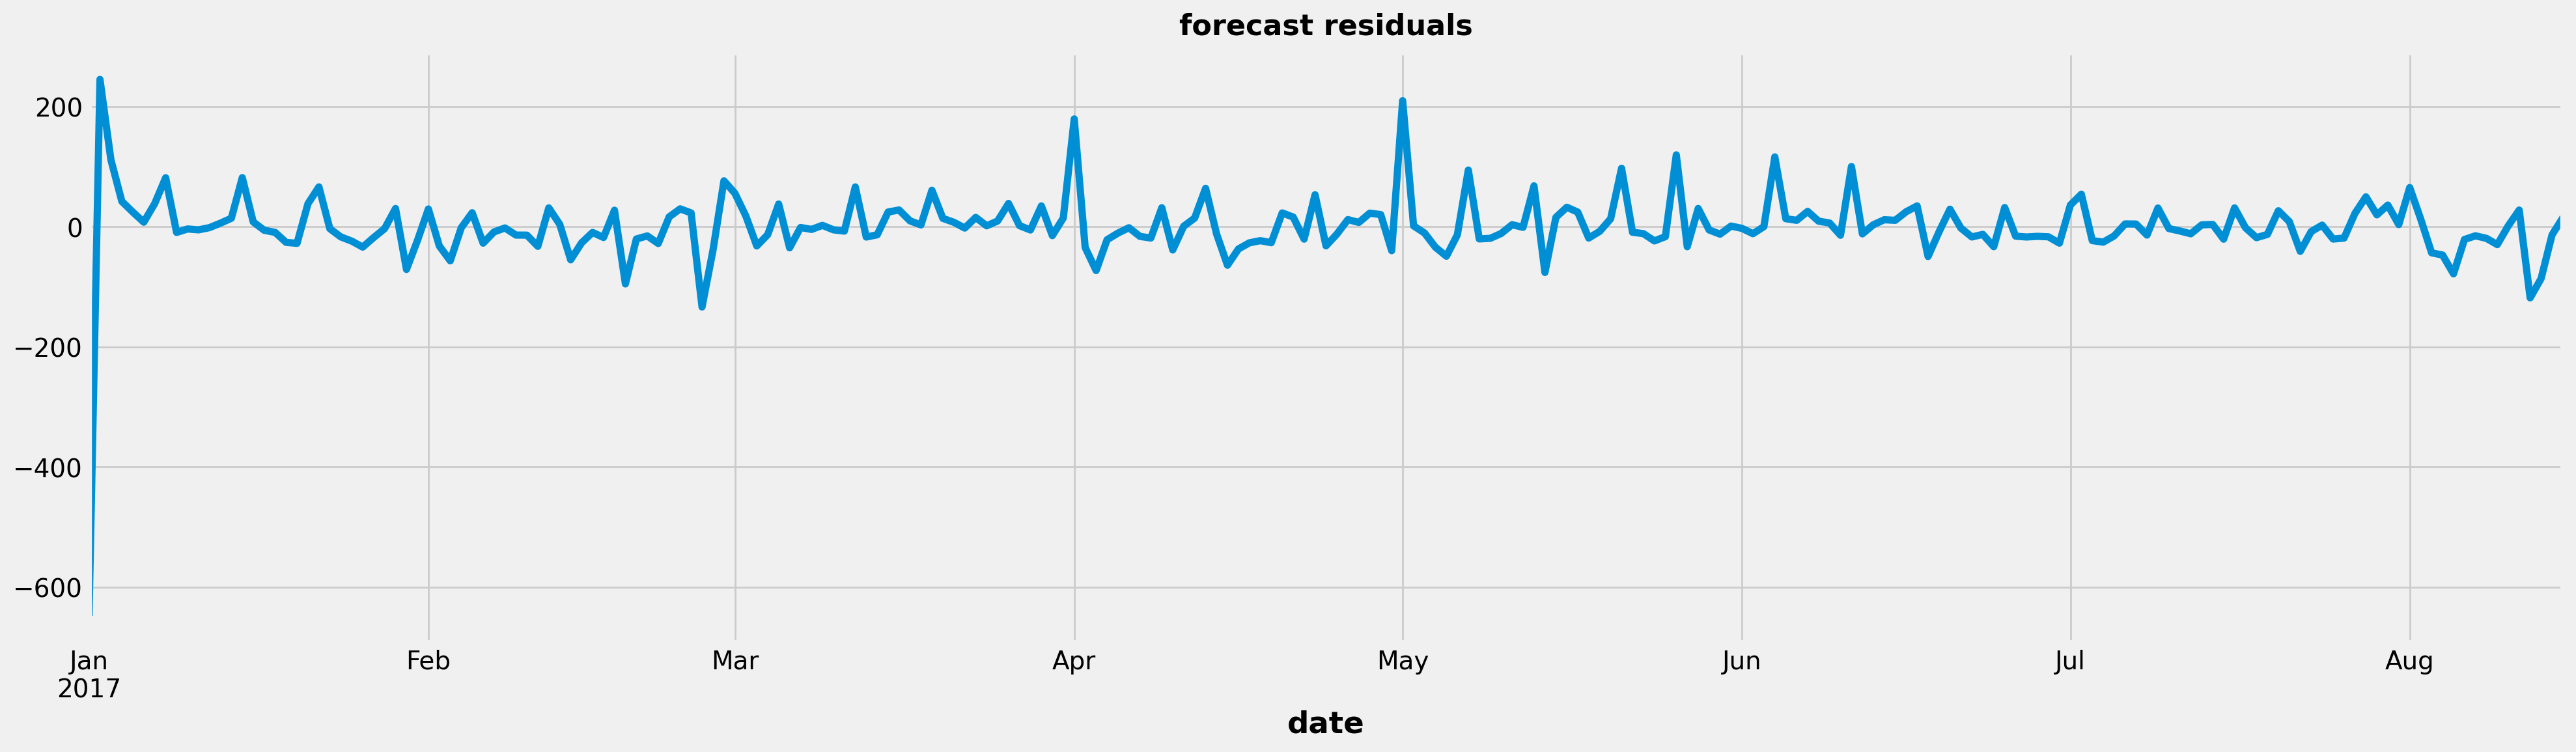

In [87]:
residuals = y - y_preds
residuals.plot(title="forecast residuals");